In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import signal, stats
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras import layers, optimizers
from scikeras.wrappers import KerasClassifier
from scipy.stats import randint
from sklearn.multioutput import MultiOutputRegressor

2025-03-08 13:17:05.078200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741420025.128549   35510 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741420025.144093   35510 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 13:17:05.212768: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData_one_sixth(cfileName):
    # Get file size in bytes.
    file_size = os.path.getsize(cfileName)
    # Each float32 is 4 bytes.
    num_floats = file_size // 4
    # Each complex sample consists of 2 floats.
    total_complex_samples = num_floats // 2
    # One-sixth of the complex samples.
    one_sixth_complex_samples = total_complex_samples // 6
    # Since each complex sample is 2 floats, calculate the count.
    count = one_sixth_complex_samples * 2
    # Read only the required number of float32 values.
    data = np.fromfile(cfileName, dtype="float32", count=count)
    # Convert to complex samples.
    complex_data = data[0::2] + 1j * data[1::2]
    return complex_data

In [3]:

def getData_half(cfileName):
    """
    Reads only the first half of the complex samples from a .cfile.
    The file is assumed to contain interleaved float32 I and Q samples.
    """
    # Get file size in bytes
    file_size = os.path.getsize(cfileName)
    # Determine total number of float32 samples in the file
    num_floats = file_size // 4
    # Each complex sample requires 2 floats.
    # The full complex array would have num_floats//2 elements.
    # To get only half of that, we need to read:
    count = (num_floats // 4) * 2  # (num_floats//4 complex samples)
    
    # Read only 'count' float32 numbers from the file
    data = np.fromfile(cfileName, dtype="float32", count=count)
    
    # Form complex samples: every pair (I, Q)
    data_complex = data[0::2] + 1j * data[1::2]
    
    return data_complex



In [4]:
num_samp_per_class = 10000
fs = 20e6        # sampling frequency
fft_size = feature_vector_size= 2048  # FFT window size
fft_overlap = 256  # overlap between segments

In [5]:
labels = ["original", "low data leakage", "moderate data leakage", "high data leakage"]

In [6]:
class_label = 0

In [7]:
original= getData_half("/media/rasi/Other/data/API-Security/hypothesis1/autheticated_firemware/original")
print(original.shape)

(212153772,)


# testing correlation heat maps

In [8]:
f_original, t_original, Zxx_original = signal.stft(original, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
# Zxx_original = Zxx_original[:num_samp_per_class]
# mag = np.abs(Zxx_original)  # Shape: (frequency_bins, time_bins)

# # Flatten STFT for correlation calculation (each column represents a time segment)
# mag_flattened = mag.T  # Shape: (time_bins, frequency_bins)

# # Compute correlation matrix
# corr_matrix = np.corrcoef(mag_flattened, rowvar=False)

# # Plot correlation heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, xticklabels=10, yticklabels=10)
# plt.title("Correlation Heatmap of STFT Features")
# plt.xlabel("Frequency Bins")
# plt.ylabel("Frequency Bins")
# plt.show()

/tmp/ipykernel_35510/492089322.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f_original, t_original, Zxx_original = signal.stft(original, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)


In [9]:

Zxx_original = Zxx_original.transpose()

X = Zxx_original[:num_samp_per_class]
y = np.full(num_samp_per_class, class_label)


print(X.shape)
print(y.shape)
del original, Zxx_original, f_original, t_original

(10000, 2048)
(10000,)


In [10]:
class_label = 1 # lower data leakage

In [11]:
low= getData_one_sixth("/media/rasi/Other/data/API-Security/hypothesis2/traning/low")
print(low.shape)

(195560075,)


In [12]:
f_low, t_low, Zxx_low = signal.stft(low, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
Zxx_low = Zxx_low.transpose()

X = np.concatenate((X, Zxx_low[:num_samp_per_class]), axis=0) 
y = np.concatenate((y, np.full(num_samp_per_class, class_label)), axis=0)

print(X.shape)
print(y.shape)
del low, Zxx_low, f_low, t_low

/tmp/ipykernel_35510/3707494615.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f_low, t_low, Zxx_low = signal.stft(low, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)


(20000, 2048)
(20000,)


In [13]:
class_label = 2

In [14]:
moderate= getData_one_sixth("/media/rasi/Other/data/API-Security/hypothesis2/traning/moderate")
print(moderate.shape)

(195581304,)


In [15]:
f_moderate, t_moderate, Zxx_moderate = signal.stft(moderate, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
Zxx_moderate = Zxx_moderate.transpose()

X = np.concatenate((X, Zxx_moderate[:num_samp_per_class]), axis=0) 
y = np.concatenate((y, np.full(num_samp_per_class, class_label)), axis=0)

print(X.shape)
print(y.shape)
del moderate, Zxx_moderate, f_moderate, t_moderate

/tmp/ipykernel_35510/3663119809.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f_moderate, t_moderate, Zxx_moderate = signal.stft(moderate, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)


(30000, 2048)
(30000,)


In [16]:
class_label = 3

In [17]:
high= getData_one_sixth("/media/rasi/Other/data/API-Security/hypothesis2/traning/high")
print(high.shape)

(194729849,)


In [18]:
f_high, t_high, Zxx_high = signal.stft(high, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
Zxx_high = Zxx_high.transpose()

X = np.concatenate((X, Zxx_high[:num_samp_per_class]), axis=0) 
y = np.concatenate((y, np.full(num_samp_per_class, class_label)), axis=0)


print(X.shape)
print(y.shape)
del high, Zxx_high, f_high, t_high

/tmp/ipykernel_35510/1495850637.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  f_high, t_high, Zxx_high = signal.stft(high, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)


(40000, 2048)
(40000,)


Building the Model

In [19]:
X = abs(X)

# scaling the features (only real part of the data can be used)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [20]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Train

In [23]:
clf = SVC()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate accuracy
print("SVM Accuracy:", accuracy_score(y_test, y_pred))

SVM Accuracy: 0.785625


# Result

In [25]:
errors = y_test - y_pred
mean_errors = np.mean(errors, axis=0)

In [26]:

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      2047
           1       0.81      0.74      0.77      1967
           2       0.77      0.80      0.79      1986
           3       0.76      0.74      0.75      2000

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.78      8000
weighted avg       0.79      0.79      0.79      8000



In [27]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1743   56   28  220]
 [ 153 1458  254  102]
 [  42  209 1596  139]
 [ 239   78  195 1488]]


In [21]:
clf = SVC()
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=skf, scoring="accuracy")

# Print results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-validation scores: [0.779125 0.7795   0.785125 0.78425  0.785875]
Mean Accuracy: 0.7828 ± 0.0029


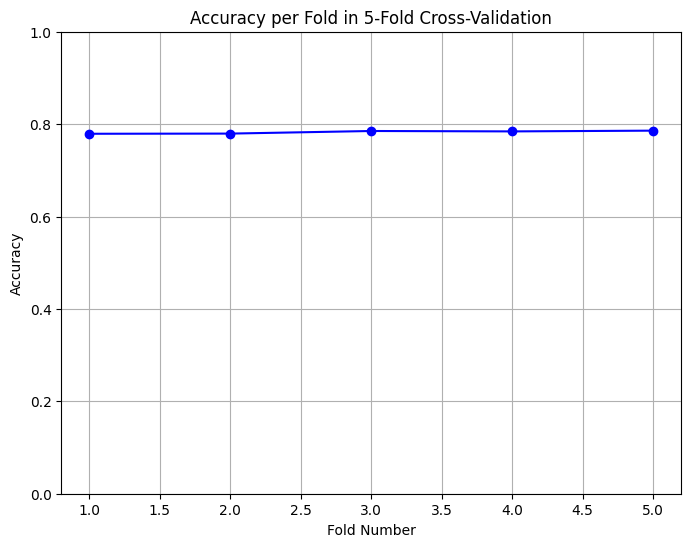

In [22]:
plt.figure(figsize=(8,6))
plt.plot(range(1, n_folds+1), cv_scores, marker='o', linestyle='-', color='blue')
plt.title(f"Accuracy per Fold in {n_folds}-Fold Cross-Validation")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Accuracy range (0 to 1)
plt.grid(True)
plt.show()

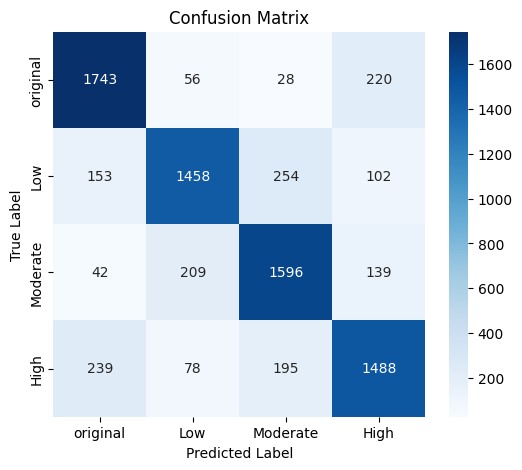

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['original','Low', 'Moderate', 'High'], yticklabels=['original', 'Low', 'Moderate', 'High'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [26]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from tensorflow import keras

# Modified model creation function that now accepts learning_rate.
def create_model(num_hidden_layers=3, neurons=128, activation="relu", learning_rate=0.001):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(feature_vector_size,)))
    
    # Dynamically add hidden layers based on num_hidden_layers.
    for _ in range(num_hidden_layers):
        model.add(keras.layers.Dense(neurons, activation=activation))
    
    # Output layer for 4 classes using softmax activation.
    model.add(keras.layers.Dense(4, activation="softmax"))
    
    # Create an optimizer instance with the specified learning rate.
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the model.
    model.compile(optimizer=optimizer, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

# Wrap the model using KerasClassifier; use 'build_fn' to pass the model creation function.
model_wrapper = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameter search space with the appropriate parameter prefixes.
param_distributions = {
    "model__num_hidden_layers": randint(1, 6),   # 1 to 5 hidden layers.
    "model__neurons": randint(50, 1024),           # Number of neurons per layer.
    "model__activation": ["relu", "tanh"],
    "model__learning_rate": uniform(0.0001, 0.01),  # Learning rate between 0.0001 and 0.0101.
    "batch_size": randint(16, 128),
    "epochs": randint(10, 50)
}

# Set up RandomizedSearchCV.
random_search = RandomizedSearchCV(
    estimator=model_wrapper,
    param_distributions=param_distributions,
    n_iter=10,  # Number of random parameter combinations to try.
    cv=3,       # 3-Fold Cross-Validation.
    verbose=1,
    n_jobs=1   # Use 1 job to reduce memory issues.
)

# Fit the search on training data.
random_search.fit(X_train, y_train)

# Print the best hyperparameters.
print("Best Hyperparameters:", random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/rasi/rasi/research/msc/side-channel/master_reseach/analysis/h1/venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
I0000 00:00:1741346376.911195  142712 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3487 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1741346379.773707  144246 service.cc:148] XLA service 0x7c7ed8004300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741346379.773949  144246 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-03-07 16:49:39.837300: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_D

Best Hyperparameters: {'batch_size': 22, 'epochs': 15, 'model__activation': 'relu', 'model__learning_rate': np.float64(0.002900697470601888), 'model__neurons': 96, 'model__num_hidden_layers': 2}


In [27]:
results_df = pd.DataFrame(random_search.cv_results_)
print(results_df.columns)  # Check the available keys

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_batch_size', 'param_epochs', 'param_model__activation',
       'param_model__learning_rate', 'param_model__neurons',
       'param_model__num_hidden_layers', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


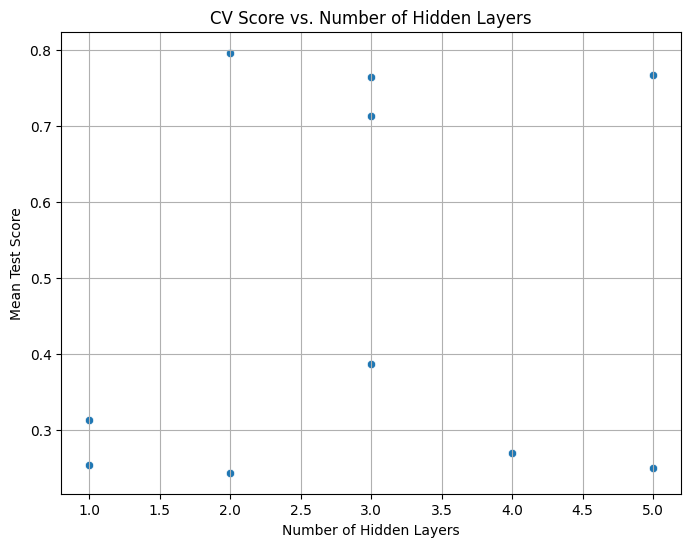

In [28]:

# Plot mean test score vs. number of hidden layers
plt.figure(figsize=(8,6))
sns.scatterplot(data=results_df, x="param_model__num_hidden_layers", y="mean_test_score")
plt.title("CV Score vs. Number of Hidden Layers")
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Mean Test Score")
plt.grid(True)
plt.show()

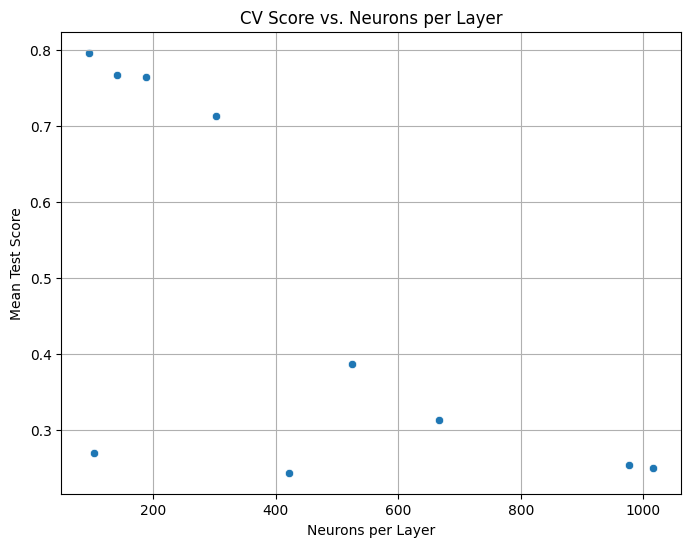

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=results_df, x="param_model__neurons", y="mean_test_score")
plt.title("CV Score vs. Neurons per Layer")
plt.xlabel("Neurons per Layer")
plt.ylabel("Mean Test Score")
plt.grid(True)
plt.show()

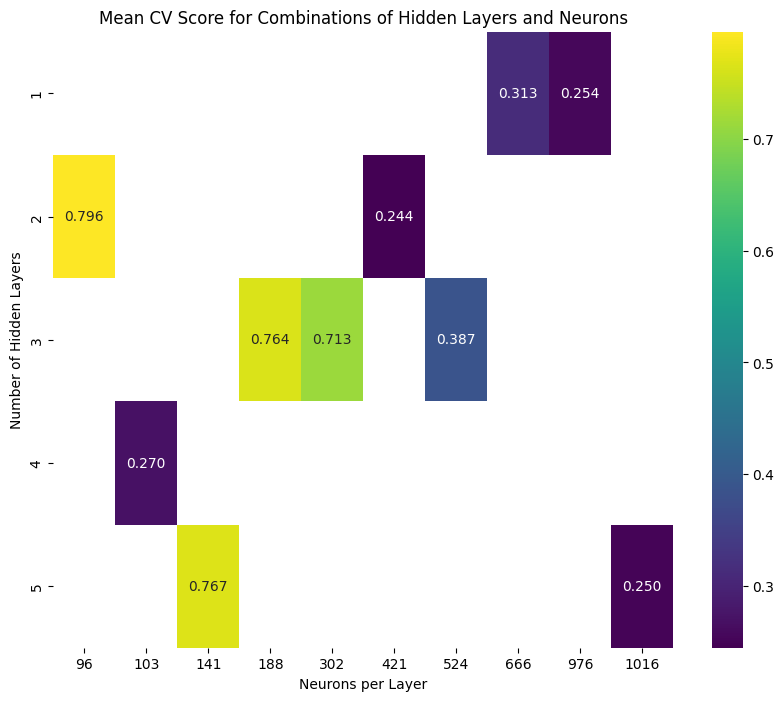

In [30]:
pivot_table = results_df.pivot_table(index="param_model__num_hidden_layers", 
                                     columns="param_model__neurons", 
                                     values="mean_test_score", 
                                     aggfunc="mean")

plt.figure(figsize=(10,8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
plt.title("Mean CV Score for Combinations of Hidden Layers and Neurons")
plt.xlabel("Neurons per Layer")
plt.ylabel("Number of Hidden Layers")
plt.show()

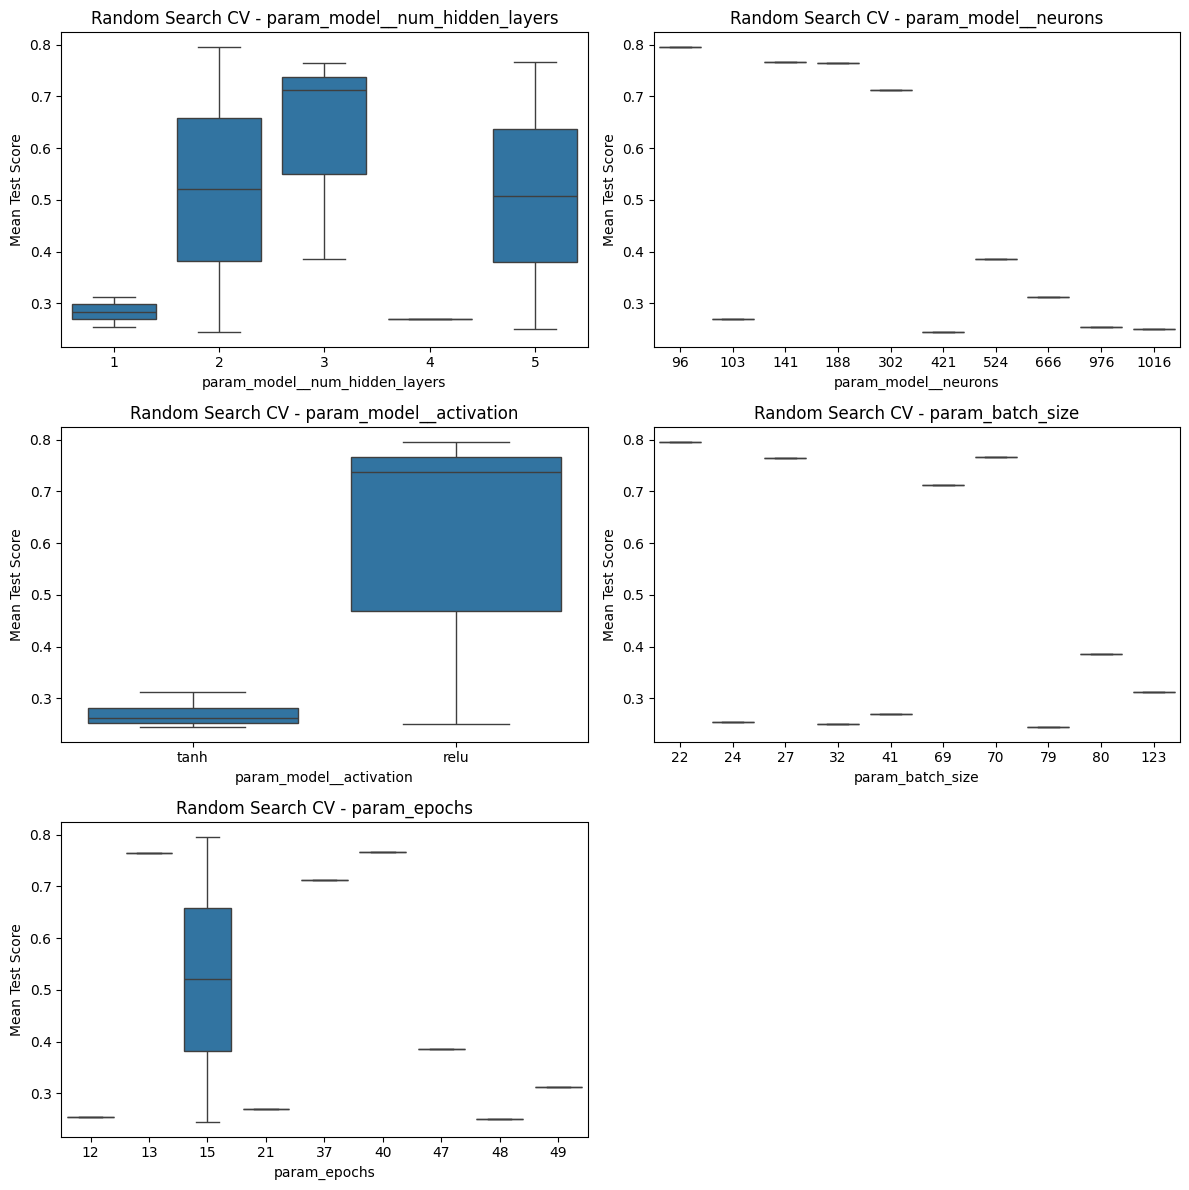

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the hyperparameters to plot, matching the keys from cv_results_
hyperparameters = [
    'param_model__num_hidden_layers',
    'param_model__neurons',
    'param_model__activation',
    'param_batch_size',
    'param_epochs'
]

# Convert cv_results_ to a DataFrame if not already done
results_df = pd.DataFrame(random_search.cv_results_)

plt.figure(figsize=(12, 12))
for i, param in enumerate(hyperparameters):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=param, y='mean_test_score', data=results_df, ax=plt.gca())
    plt.title(f'Random Search CV - {param}')
    plt.xlabel(param)
    plt.ylabel('Mean Test Score')
plt.tight_layout()
plt.show()


# neural model

In [35]:
# Best Hyperparameters: {'batch_size': 22, 'epochs': 15, 'model__activation': 'relu', 'model__learning_rate': np.float64(0.002900697470601888),
#  'model__neurons': 96, 'model__num_hidden_layers': 2}
model_test = keras.models.Sequential()
    
# Input layer (assuming a 1D feature vector of length 'feature_vector_size')
model_test.add(keras.layers.Input(shape=(feature_vector_size,)))

# 1st hidden layer
model_test.add(keras.layers.Dense(256, activation="relu"))
# 2nd hidden layer
model_test.add(keras.layers.Dense(96, activation="relu"))
# 3rd hidden layer
# model_test.add(keras.layers.Dense(50, activation="relu"))
# 4th hidden layer
# model_test.add(keras.layers.Dense(256, activation="relu"))

# Output layer (4 classes, using softmax)
model_test.add(keras.layers.Dense(4, activation="softmax"))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model_test.compile(
        optimizer=optimizer, 
        loss="sparse_categorical_crossentropy", 
        metrics=["accuracy"]
    )

model_test.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 96)             │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,604 (2.10 MB)

 Trainable params: 549,604 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = model_test.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3809 - loss: 1.3015 - val_accuracy: 0.5858 - val_loss: 1.0345
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5909 - loss: 0.9901 - val_accuracy: 0.6617 - val_loss: 0.8608
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6796 - loss: 0.8301 - val_accuracy: 0.7044 - val_loss: 0.7681
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7334 - loss: 0.7110 - val_accuracy: 0.7258 - val_loss: 0.6993
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7750 - loss: 0.6126 - val_accuracy: 0.7431 - val_loss: 0.6560
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7941 - loss: 0.5508 - val_accuracy: 0.7572 - val_loss: 0.6222
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8097 - loss: 0.5096 - val_accuracy: 0.7809 - val_loss: 0.5741
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8253 - loss: 0.4690 - val_accuracy: 0.

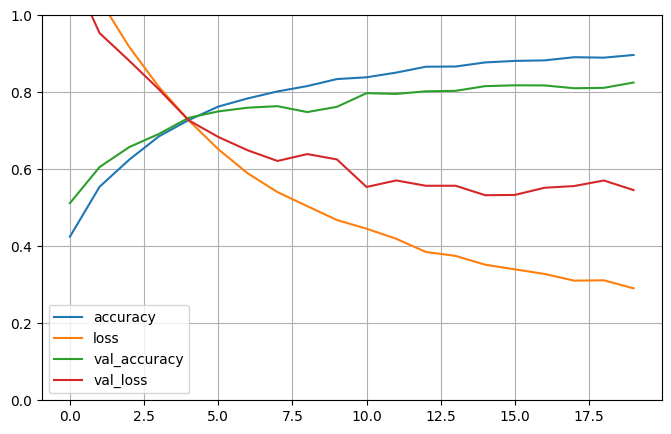

In [46]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [47]:
results = model_test.evaluate(X_test, y_test)
print("test loss, test acc:", results)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8201 - loss: 0.5612
test loss, test acc: [0.5500054359436035, 0.8224999904632568]


In [48]:
results = model_test.evaluate(X_test, y_test)
print("test loss, test acc:", results)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8201 - loss: 0.5612
test loss, test acc: [0.5500054359436035, 0.8224999904632568]


In [51]:
y_pred = np.argmax(model_test.predict(X_test), axis=1) 

if y_test.ndim > 1:  # If y_test is one-hot encoded
    y_test = np.argmax(y_test, axis=1)

print(y_pred)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[0 1 2 ... 1 0 3]


In [52]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[1699  111   72  165]
 [  71 1691  102  103]
 [  45  220 1590  131]
 [ 187  115   98 1600]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2047
           1       0.79      0.86      0.82      1967
           2       0.85      0.80      0.83      1986
           3       0.80      0.80      0.80      2000

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000



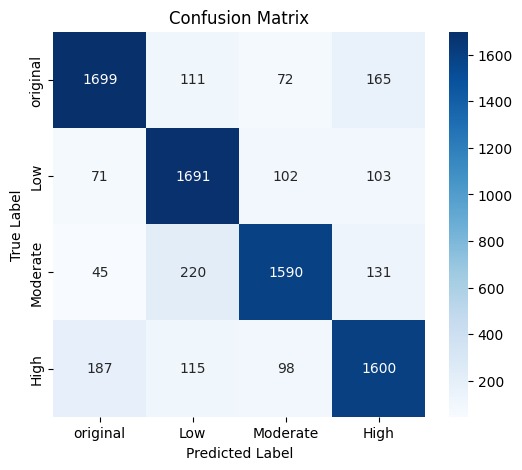

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['original','Low', 'Moderate', 'High'], yticklabels=['original', 'Low', 'Moderate', 'High'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# other

In [43]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(feature_vector_size,)))

model.add(keras.layers.Dense(1400, activation="relu"))
model.add(keras.layers.Dense(800, activation="relu"))
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(250, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 1400)           │     2,868,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 800)            │     1,120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 500)            │       400,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,541,260 (17.32 MB)

 Trainable params: 4,541,260 (17.32 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [45]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./leakage.keras", save_best_only=True)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[checkpoint_cb])

Epoch 1/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3089 - loss: 1.5817 - val_accuracy: 0.3544 - val_loss: 1.3153
Epoch 2/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4662 - loss: 1.2748 - val_accuracy: 0.5289 - val_loss: 1.1797
Epoch 3/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5261 - loss: 1.1409 - val_accuracy: 0.5675 - val_loss: 1.0626
Epoch 4/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5561 - loss: 1.0348 - val_accuracy: 0.5719 - val_loss: 1.0116
Epoch 5/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5939 - loss: 0.9716 - val_accuracy: 0.6189 - val_loss: 0.9621
Epoch 6/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6212 - loss: 0.9157 - val_accuracy: 0.5606 - val_loss: 1.0009
Epoch 7/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6531 - loss: 0.8625 - val_accuracy: 0.6589 - val_loss: 0.8876
Epoch 8/50
1013/1013 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6836 - loss: 0.8178 - 

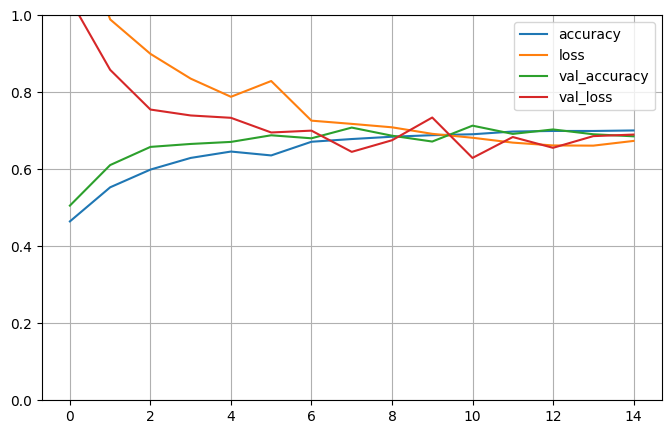

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [35]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

NameError: name 'model' is not defined

In [49]:
model = keras.models.load_model("./leakage.keras")

In [50]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8269 - loss: 0.5907
test loss, test acc: [0.5573269724845886, 0.827750027179718]


In [62]:


y_pred = np.argmax(model.predict(X_test), axis=1) 

if y_test.ndim > 1:  # If y_test is one-hot encoded
    y_test = np.argmax(y_test, axis=1)

print(y_pred)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[2 1 0 ... 1 0 0]


In [67]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[832  57  30  90]
 [ 49 826  71  42]
 [ 33  80 871  51]
 [ 78  52  56 782]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1009
           1       0.81      0.84      0.82       988
           2       0.85      0.84      0.84      1035
           3       0.81      0.81      0.81       968

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



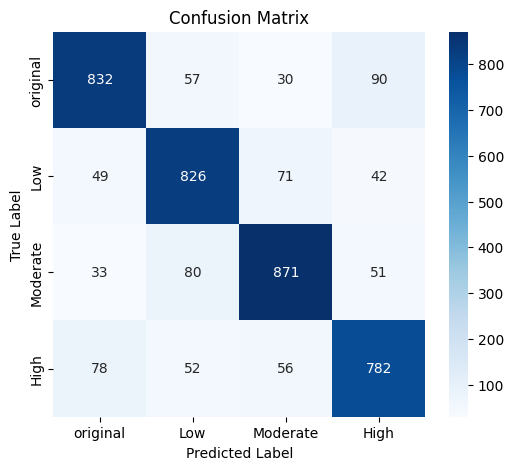

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['original','Low', 'Moderate', 'High'], yticklabels=['original', 'Low', 'Moderate', 'High'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()